In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os 

In [14]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

In [15]:
class Day_20cnn(nn.Module):
    def __init__(self):
        super(Day_20cnn, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(5,3),padding=(7,1),stride=(3,1),dilation=(2,1))
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchnorm1=nn.BatchNorm2d(64,affine=True)
        self.relu1=nn.LeakyReLU()
        self.pool1=nn.MaxPool2d(kernel_size=(2,1))
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,3),padding=(2,1),stride=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchnorm2=nn.BatchNorm2d(128,affine=True)
        self.relu2=nn.LeakyReLU()
        self.pool2=nn.MaxPool2d(kernel_size=(2,1))
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(5,3),padding=(2,1),stride=1)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.batchnorm3=nn.BatchNorm2d(256,affine=True)
        self.relu3=nn.LeakyReLU()
        self.pool3=nn.MaxPool2d(kernel_size=(2,1))
        self.fc= nn.Linear(46080,2)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        self.drop = nn.Dropout(p=0.5)
        # self.sfm=nn.CrossEntropyLoss()
    def forward(self,x):
        y = self.conv1(x)
        y = self.batchnorm1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.batchnorm2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.batchnorm3(y)
        y = self.relu3(y)
        y = self.pool3(y)
        # print(y.shape)
        y = y.view(y.shape[0],-1)
        # print(y.shape)
        y = self.fc(y)
        y = self.drop(y)
        # y=self.sfm(y)
        return y


In [16]:
import pandas as pd
import numpy as np
np.random.seed(10)
IMAGE_WIDTH={5:15, 20:60, 60:180}
IMAGE_HEIGHT={5:32, 20:64, 60:96}

def data_set(dir, year_index, in_size, out_size):
    year = year_index[0]
    img_path = os.path.join(dir,"monthly_20d",f"20d_month_has_vb_[20]_ma_{year}_images.dat")
    label_path = os.path.join(dir,"monthly_20d",f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")
    image = np.memmap(img_path,dtype=np.uint8,mode='r').reshape(-1,IMAGE_HEIGHT[in_size],IMAGE_WIDTH[out_size])
    label = pd.read_feather(label_path)

    for year in year_index[1:]:
        img_path = os.path.join(dir,"monthly_20d",f"20d_month_has_vb_[20]_ma_{year}_images.dat")
        label_path = os.path.join(dir,"monthly_20d",f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")
        img = np.memmap(img_path,dtype=np.uint8,mode='r').reshape(-1,IMAGE_HEIGHT[in_size],IMAGE_WIDTH[out_size])
        lbl = pd.read_feather(label_path)
        image = np.concatenate((image,img),axis=0)
        label = pd.concat([label,lbl])
    return image, label

In [17]:
# # test
# img_dir = "/home/ywangtb/ai_fintech"
# test_index = np.arange(2001, 2020, 1)
# # test_index = np.arange(2001, 2020, 1)
# train = False
# in_size = 20
# out_size = 20
# test_image, test_label = data_set(img_dir, test_index, in_size, out_size)

In [18]:
class Stock(torch.utils.data.Dataset):
    def __init__(self, image, label,transform):
        self.image = image
        self.label = label
        self.transform = transform
        self.pre_process()
    def __len__(self):
        return len(self.label)
    def __getitem__(self, index):
        image = self.transform(self.image[index])
        return image, self.label.iloc[index, -1]
    def pre_process(self):
        self.label['Label_20d'] = self.label['Ret_20d']
        self.label.loc[self.label['Label_20d']<=0, 'Label_20d']=0
        self.label.loc[self.label['Label_20d']>0, 'Label_20d']=1
        self.label.loc[pd.isnull(self.label['Label_20d']), 'Label_20d']=0


In [19]:
# mytransform = torchvision.transforms.ToTensor()
# test_data = Stock(test_image, test_label, mytransform)
# test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=128,shuffle=True,num_workers=2)
# loaders = {'test': test_loader}

In [20]:
import os
# import re
import time
# import scipy.stats


def softmax(x):
    """Compute softmax values for each sets of scores in x."""

    return np.exp(x) / np.sum(np.exp(x), axis=0)

# def train_model(model):
#     since = time.time()
#     # torch.save(model,'save.pt')
#     model.eval()
#     print("Now print the test outcome")
#     phase = "test"
#     inputs, labels = loaders[phase]
#     if use_gpu:
#     # inputs = inputs.to(device)
#     # labels = labels.to(device)
#         inputs = inputs.cuda()
#         labels = labels.cuda()

#     # optimizer.zero_grad()

#     outputs = model(inputs)
#     # _, preds = torch.max(outputs.data, 1)
#     labels = labels.long()
#     # loss = criterion(outputs, labels)
#     # epoch_loss = loss.data.item()
#     prob = softmax(outputs.cpu().detach().numpy()) 
#     # epoch_error = 1 - accuracy(outputs.data, labels.data)[-1].item() / 100
#     # print(f'{phase} loss: {epoch_loss:.4f}; error: {epoch_error:.4f}')
#     time_elapsed = time.time() - since
#     print(
#         f'prediction complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
#     )
#     return prob


In [21]:
# year = 2017
# images = np.memmap(os.path.join("/Users/evan_wang/Library/CloudStorage/OneDrive-Microsoft/code/python/pytorch/data","monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
#                         (-1, 64, 60))
# im_tensor=torch.from_numpy(images)/255
# im_tensor=im_tensor.reshape(len(images),1,64,60)
# im_tensor.size()
# batch = im_tensor[:128]

# img_dir = "/Users/evan_wang/Library/CloudStorage/OneDrive-Microsoft/code/python/pytorch"
# model=torch.load(os.path.join(img_dir,"20cnn.pt"), map_location='cpu')
# output1=model(batch.float())
# output1[0].shape
# print(output1)
# for i in range(0,output1.shape[0]):
#      print(softmax(output1[i].cpu().detach().numpy())) 

In [22]:
# # test_image, test_label 
# test_image_torch = torch.from_numpy(test_image)
# test_image_torch = test_image_torch.reshape(len(test_image),1,64,60)
# batch = test_image_torch[:2000]/255

# img_dir = "/home/ywangtb/ai_fintech"
# model=torch.load(os.path.join(img_dir,"20cnn.pt"), map_location='cpu')
# output1=model(batch.float())

# # output1[0].shape
# # print(output1)
# for i in range(0,output1.shape[0]):
#      print(softmax(output1[i].cpu().detach().numpy())) 

# # img_dir = "/Users/evan_wang/Library/CloudStorage/OneDrive-Microsoft/code/python/pytorch"
# # model=torch.load(os.path.join(img_dir,"20cnn.pt"), map_location='cpu')
# # prob = train_model(model)
# # print(prob)

In [23]:
# class Day_20cnn(nn.Module):
#     def __init__(self):
#         super(Day_20cnn, self).__init__()
#         self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(5,3),padding=(7,1),stride=(3,1),dilation=(2,1)),
#                                   nn.BatchNorm2d(64), # Accelerating Deep Network Training by Reducing Internal Covariate Shift, normliaze data/features
#                                   nn.LeakyReLU(),
#                                   nn.MaxPool2d(kernel_size=(2,1))
#                                   )
#         self.conv2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,3),padding=(2,1),stride=1),
#                                   nn.BatchNorm2d(128),
#                                   nn.LeakyReLU(),
#                                   nn.MaxPool2d(kernel_size=(2,1))
#                                   )
#         self.conv3 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(5,3),padding=(2,1),stride=1),
#                                   nn.BatchNorm2d(256),
#                                   nn.LeakyReLU(),
#                                   nn.MaxPool2d(kernel_size=(2,1))
#                                   )
#         self.fc1 = nn.Sequential(nn.Dropout(p=0.5),
#                                  nn.Linear(46080,2))
        
#     def forward(self,x):
#         y = self.conv1(x)
#         y = self.conv2(y)
#         y = self.conv3(y)
#         y = y.view(y.shape[0],-1)
#         y = self.fc1(y)
#         # y=self.sfm(y)
#         return y

In [24]:
model_dir = "/home/ywangtb/ai_fintech/model"
model = torch.load(os.path.join(model_dir,"20cnn.pt"), map_location='cpu')

img_dir = "/home/ywangtb/ai_fintech"
# model = torch.load(os.path.join(img_dir,"save.pt"), map_location='cpu')

# output1=model(batch.float())

test_year=list(range(2000,2020))
# test_year=list(range(2000,2020))
test_set=[]
step=500
for year in test_year:
    torch.cuda.empty_cache()
    images = np.memmap(os.path.join(img_dir,"monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, 64, 60))
    im_tensor=torch.from_numpy(images[:])/255
    im_tensor=im_tensor.reshape(len(images),1,64,60)
    print(len(im_tensor))
    up_prob=[]
    for i in range(0,len(im_tensor),step):
        # output1 = model(im_tensor[i:i+step].float().cuda())
        output1 = model(im_tensor[i:i+step].float())
        for j in range(0,output1.shape[0]):
            up_prob.append(softmax(output1[j].cpu().detach().numpy())[1])
    assert len(up_prob)==len(im_tensor)
    mydataframe=pd.read_feather(os.path.join(img_dir,"monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))[['Date','StockID','Ret_20d','MarketCap']]
    mydataframe.insert(mydataframe.shape[1],'Up_Prob',up_prob)
    test_set.append(mydataframe)

98148
91985
85729
80894
79512
79883
80163
81140
78186
70065
68111
67325
66250
65486
67302
68827
68141
67858
68481
68637


In [25]:
test_set

[            Date StockID   Ret_20d    MarketCap   Up_Prob
 0     2000-01-31   10001  0.015383   19906.2500  0.574962
 1     2000-02-29   10001 -0.030675   20212.5000  0.475310
 2     2000-03-31   10001  0.031251  -19712.0000  0.562051
 3     2000-04-28   10001 -0.011582  -19943.0000  0.498351
 4     2000-05-31   10001 -0.036619  -19481.0000  0.528462
 ...          ...     ...       ...          ...       ...
 98143 2000-10-31   93105 -0.045638  384013.7500  0.534124
 98144 2000-11-30   93105  0.284617  376229.6875  0.548366
 98145 2000-12-29   93105  0.075271  482460.7500  0.467811
 98146 2000-01-31   93316  0.002065   46615.2500  0.403079
 98147 2000-02-29   93316       NaN   46711.5625  0.448682
 
 [98148 rows x 5 columns],
             Date StockID   Ret_20d      MarketCap   Up_Prob
 0     2001-01-31   10001 -0.012658   24667.750000  0.506816
 1     2001-02-28   10001  0.058267   24414.000000  0.568788
 2     2001-03-30   10001 -0.025001   25090.000000  0.427256
 3     2001-04-30  

In [26]:
test_data=pd.concat(test_set) # covert from list to one df
test_data.head()
test_data=test_data.dropna(axis=0) 

In [27]:
test_data['Decile']=test_data.groupby('Date')['Up_Prob'].transform(lambda x: pd.qcut(x, 10, labels=False)) # transform 10 data into 10 box with index 0-9

In [28]:
##R20R20:equal weight  + value weighted(Market Cap?)
##Todo 1.对每一个date，计算相同decile内Ret equal_weight,weighted_weight portfolio,再对时间平均
df = test_data.sort_values(by = 'Date')
df.head()

,Date,StockID,Ret_20d,MarketCap,Up_Prob,Decile
0,2000-01-31,10001,0.015383,19906.2500,0.574962,8
84871,2000-01-31,86709,0.125365,536580.6250,0.449550,1
28347,2000-01-31,75376,0.097651,140074.0625,0.505976,4
28359,2000-01-31,75381,0.155341,580173.2500,0.485496,3
84859,2000-01-31,86685,-0.132257,514987.5000,0.486470,3


In [29]:
# 等权持有每个decile中的股票，得到每个decile在每个月的收益，因此求和并除以总年份; 每个decile平均年收益
newdf = pd.DataFrame(df.groupby(['Date','Decile'])['Ret_20d'].mean())
year = len(newdf)/10/12
newdf = newdf.groupby(['Decile']).sum()
# in this, we get the decile return in two year?
equal_ann = newdf['Ret_20d']/year
equal_ann

Decile
0   -0.050636
1    0.009016
2    0.036390
3    0.055039
4    0.064282
5    0.089813
6    0.107600
7    0.135017
8    0.142021
9    0.212441
Name: Ret_20d, dtype: float64

In [30]:
# 构建portfolio 做多1分位数 做空10分位数
# 计算annually sharpe 
# yearly sharpe == monthly sharpe*sqrt(12)
df_short = df[df['Decile'] == 0]
df_long = df[df['Decile'] == 9]
df_long = df_long.groupby('Date')['Ret_20d'].mean()
df_short = df_short.groupby('Date')['Ret_20d'].mean()
df_portfolio  = df_long - df_short
sharpe_ratio = (df_portfolio.mean() - 0.03/12)/df_portfolio.std()*pow(12,0.5)
sharpe_ratio

1.7374732124667993

In [31]:
df_portfolio.mean()

0.02192310182703309

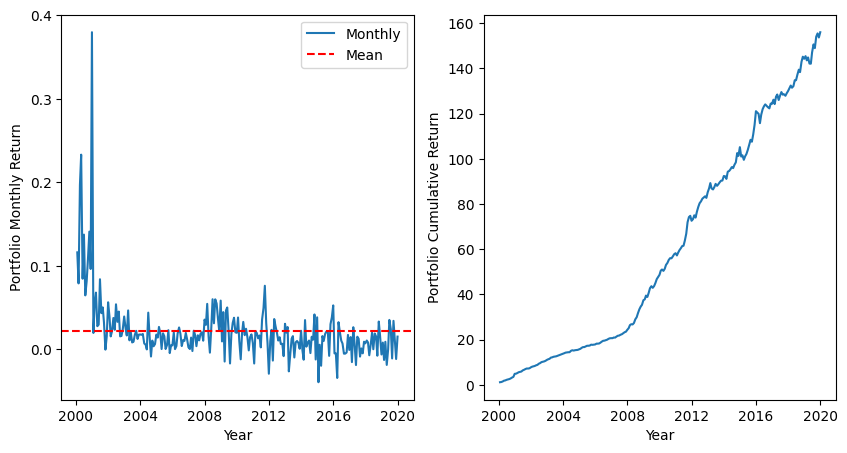

In [32]:
import matplotlib.pyplot as plt
fig,  (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
x = df_portfolio.index
y = df_portfolio
ax1.plot(x, y, label='Monthly') 
ax1.axhline(y.mean(),color='r',linestyle='--', label='Mean')
# plt.plot(x,y)
# plt.plot(df_portfolio.mean())
ax1.set_ylabel("Portfolio Monthly Return")
ax1.set_xlabel("Year")
ax1.legend()


ax2.plot((df_portfolio+1).cumprod())
ax2.set_ylabel("Portfolio Cumulative Return")
ax2.set_xlabel("Year")

plt.show()


In [33]:
import numpy 
np.log((df_portfolio+1).cumprod()[-1] )/20

/tmp/ipykernel_21427/2711426210.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.log((df_portfolio+1).cumprod()[-1] )/20


0.25249073741903894

In [34]:
(df_portfolio+1).cumprod()[-1] 
# e^r20 = 155
# r = ln(155)/20

/tmp/ipykernel_21427/2296344336.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df_portfolio+1).cumprod()[-1]


155.99356374925085

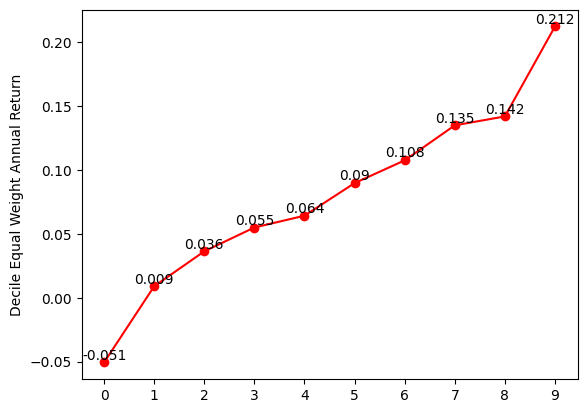

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 每个decile平均年收益
x = pd.Series([-0.050636,0.009016,0.036390,0.055039,0.064282,0.089813,0.107600,0.135017, 0.142021, 0.212441])
plt.plot(x,marker='o', linestyle='-',color='r')
plt.ylabel("Decile Equal Weight Annual Return")
plt.xticks(np.arange(0,10))
for a, b in zip(x.index, round(x,3)):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)
plt.show()

In [46]:
# calculate the max drawdown
cum_value_max = (df_portfolio+1).cumprod().cummax()
cum_value = (df_portfolio+1).cumprod()
max_drawdown = ((cum_value_max - cum_value)/cum_value_max)
max_drawdown_value = max_drawdown.max()
max_drawdown_date = max_drawdown.index[max_drawdown.argmax()]

# max_drawdown = ((np.log((df_portfolio+1).cumprod()).cummax() - np.log((df_portfolio+1).cumprod()))/np.log((df_portfolio+1).cumprod()).cummax()).max()
print(max_drawdown_value, max_drawdown_date)

0.05328347016887776 2015-03-31 00:00:00


In [37]:
# 等权持有每个decile中的股票，得到每个decile在每个月的标准差，并将标准差在所有月份求平均
newdfs = pd.DataFrame(df.groupby(['Date','Decile'])['Ret_20d'].std())
long=12*20
newdfs = newdfs.groupby(['Decile']).sum()
equal_annstd = newdfs['Ret_20d']/long
equal_annstd

Decile
0    0.160983
1    0.152641
2    0.153304
3    0.147891
4    0.144911
5    0.144088
6    0.145661
7    0.145462
8    0.139368
9    0.147234
Name: Ret_20d, dtype: float64

In [38]:
# 等权持有每个decile中的股票，得到每个decile在每个月的收益，平均月收益
# equal_decile=pd.DataFrame(df.groupby(['Date','Decile'])['Ret_20d'].mean()).groupby(['Decile']).mean()
# equal_decile

In [39]:
# value-weight portfolio
# def weightreturn(group, avg_name, weight_name):
#     d = group[avg_name]
#     w = group[weight_name]
#     return (d * w).sum() / w.sum()
# market_decile=pd.DataFrame(df.groupby(['Date','Decile']).apply(weightreturn,'Ret_20d','MarketCap')).groupby(['Decile']).mean()
# market_decile

# newdf2 = pd.DataFrame(df.groupby(['Date','Decile']).apply(weightreturn,'Ret_20d','MarketCap'))
# newdf2 = newdf2.groupby(['Decile']).sum()
# weight_ann = newdf2/20
# weight_ann

# newdf2 = pd.DataFrame(df.groupby(['Date','Decile']).apply(weightreturn,'Ret_20d','MarketCap'))
# newdf2 = newdf2.groupby(['Decile']).std()
# # weight_ann = newdf2/20
# # weight_ann
# newdf2*np.sqrt(20)

In [40]:
mom_r=[0.07,0.07,0.09,0.09,0.09,0.11,0.12,0.14,0.14,0.14]
str_r=[0.05,0.08,0.10,0.10,0.11,0.10,0.12,0.10,0.09,0.16]
wstr_r=[0.01,0.06,0.09,0.10,0.11,0.11,0.11,0.11,0.13,0.19]
mon_std=[0.37,0.26,0.215,0.18,0.16,0.13,0.12,0.13,0.14,0.19]
str_std=[0.23,0.18,0.16,0.15,0.155,0.16,0.17,0.18,0.235,0.32]
wstr_std=[0.24,0.18,0.16,0.15,0.13,0.155,0.165,0.176,0.225,0.28]

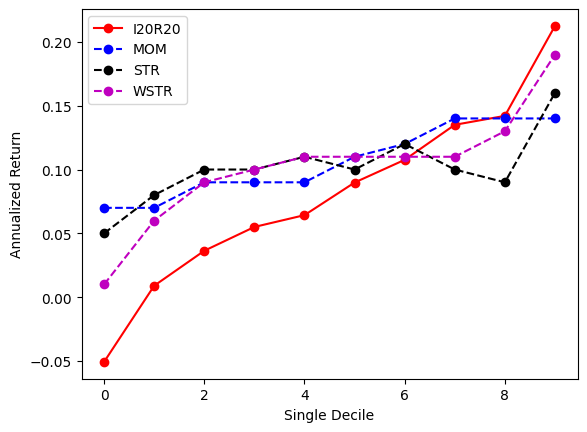

In [41]:
import matplotlib.pyplot as plt
x=range(10)
lines=plt.plot(x,equal_ann,x,mom_r,x,str_r,x,wstr_r)
plt.setp(lines[0],marker='o', linestyle='-',color='r',label='I20R20')
plt.setp(lines[1],marker='o', linestyle='--',color='b',label='MOM')
plt.setp(lines[2],marker='o', linestyle='--',color='k',label='STR')
plt.setp(lines[3],marker='o', linestyle='--',color='m',label='WSTR')

plt.xlabel('Single Decile')
plt.ylabel('Annualized Return')
plt.legend()

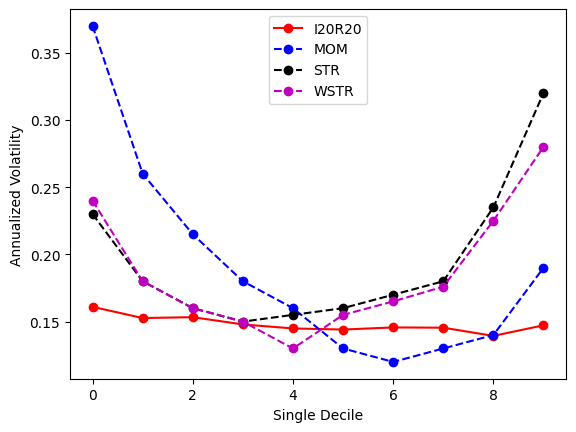

In [42]:
x=range(10)
lines=plt.plot(x,equal_annstd,x,mon_std,x,str_std,x,wstr_std)
plt.setp(lines[0],marker='o', linestyle='-',color='r',label='I20R20')
plt.setp(lines[1],marker='o', linestyle='--',color='b',label='MOM')
plt.setp(lines[2],marker='o', linestyle='--',color='k',label='STR')
plt.setp(lines[3],marker='o', linestyle='--',color='m',label='WSTR')

plt.xlabel('Single Decile')
plt.ylabel('Annualized Volatility')
plt.legend()